In [95]:
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils.containers import TrainingData
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP

from tqdm import tqdm

----

In [135]:
from archai.algos.evolution_pareto_image_seg.remote_benchmark import RemoteAzureBenchmark
from archai.algos.evolution_pareto_image_seg.model import SegmentationNasModel
from archai.algos.evolution_pareto_image_seg.segmentation_trainer import LightningModelWrapper
from archai.search_spaces.discrete_search_spaces.segmentation_search_spaces.discrete_search_space_segmentation import DiscreteSearchSpaceSegmentation
from archai.search_spaces.discrete_search_spaces.segmentation_search_spaces.discrete_search_space_segmentation import ArchWithMetaData
from archai.search_spaces.discrete_search_spaces.utils import get_graph_paths, get_graph_ngrams

In [97]:
random_model = DiscreteSearchSpaceSegmentation('f', min_layers=3, max_layers=16)

In [98]:
%%time
model_list = [random_model.random_sample() for _ in tqdm(range(50))]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [06:25<00:00,  7.71s/it]

CPU times: user 2h 18min 58s, sys: 16.7 s, total: 2h 19min 15s
Wall time: 6min 25s


In [183]:
import numpy as np
import torch
from copy import deepcopy
from typing import List, Tuple, Dict


def _get_graph_with_channels(m: ArchWithMetaData):
    g = deepcopy(m.arch.graph)
    ch_per_scale = m.arch.channels_per_scale
    
    scales = [1, 2, 4, 8, 16, 32]

    ch_per_scale = {
        scale: ch_per_scale['base_channels'] +\
               (scale_i)*ch_per_scale['delta_channels']
        for scale_i, scale in enumerate(scales)
    }
    
    for node_attrs in g.values():
        node_attrs['channels'] = ch_per_scale[node_attrs['scale']]
    
    return g


class PathEncoder():
    def __init__(self, node_vars: List, path_length: int = -1):
        self.vocab = None
        self.node_vars = node_vars
        self.path_length = path_length
        self.should_calc_channels = 'channels' in node_vars
            
    
    def fit(self, model_list: List[ArchWithMetaData]) -> None:
        paths = {
            p for m in model_list for p in self.encode(m)
        }
        
        self.vocab = list(paths)
        self.path2idx = {path: i for i, path in enumerate(self.vocab)}
    
    def transform(self, model_list: List[ArchWithMetaData]) -> torch.Tensor:
        if not self.vocab:
            raise ValueException('PathEncoder is not fitted.')
        
        arr = np.zeros((len(model_list), len(self.vocab)))
        
        for model_idx, m in enumerate(model_list):
            idxs = np.array([
                self.path2idx[p] for p in self.encode(m)
                if p in self.path2idx
            ])
            if idxs.any():
                arr[model_idx][idxs] = 1
            
        return arr

    def fit_transform(self, x: List[ArchWithMetaData]) -> torch.Tensor:
        self.fit(x)
        return self.transform(x)
    
    def encode(self, m: ArchWithMetaData) -> List[Tuple[Tuple]]:
        g = _get_graph_with_channels(m) if self.should_calc_channels else m.arch.graph
            
        if self.path_length == -1:
            return get_graph_paths(g, node_vars=self.node_vars)
        
        return get_graph_ngrams(g, node_vars=self.node_vars, n=self.path_length)

In [184]:
model_list[0].arch.channels_per_scale

{'base_channels': 48,
 'delta_channels': 24,
 1: 48,
 2: 72,
 4: 96,
 8: 120,
 16: 144}

In [353]:
%%time
encoder1 = PathEncoder(['scale'], path_length=-1)
encoder1.fit(model_list)

encoder2 = PathEncoder(['op'], path_length=-1)
encoder2.fit(model_list)

CPU times: user 34 ms, sys: 37 µs, total: 34 ms
Wall time: 32.9 ms


In [354]:
X = np.concatenate([encoder1.transform(model_list), encoder2.transform(model_list)], axis=1)

In [355]:
import matplotlib.pyplot as plt

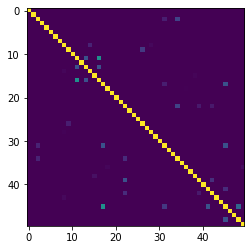

In [356]:
sim_matrix = (X @ X.T)/np.diag(X@X.T)
plt.imshow(sim_matrix)

In [357]:
pair_array = np.array([
    [i, j, sim_matrix[i,j]]
    for i in range(sim_matrix.shape[0])
    for j in range(sim_matrix.shape[1])
    if sim_matrix[i, j] != 1
])

In [358]:
pair_array[:, 2].argsort()[-10:]

array([1933, 1563,  797, 2397,  551, 2246, 2252,  554,  795, 2222])

In [366]:
pair_array[554]

array([11. , 16. ,  0.5])

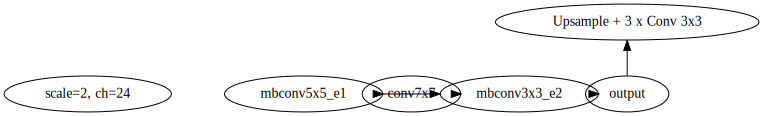

In [368]:
model_list[11].arch.view()

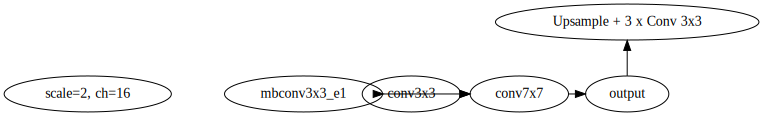

In [369]:
model_list[16].arch.view()